In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import diffusion_gosai_update
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
import dataloader_gosai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import oracle
from scipy.stats import pearsonr
import torch
from tqdm import tqdm
import diffusion_gosai_cfg
from utils import set_seed
set_seed(0, use_cuda=True)
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

/n/home03/mfli/.conda/envs/sedd/lib/python3.9/site-packages/norns/cfg.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


=> Seed of the run set to 0


In [3]:
base_path = '/n/holylabs/LABS/sitanc_lab/Users/mfli/DRAKES_test/data_and_model'

In [4]:
# our model
CKPT_PATH = os.path.join(base_path, 'mdlm/reward_bp_results_final/finetuned.ckpt')
NUM_SAMPLE_BATCHES = 10
NUM_SAMPLES_PER_BATCH = 64

In [5]:
# reinitialize Hydra
GlobalHydra.instance().clear()

# Initialize Hydra and compose the configuration|
initialize(config_path="configs_gosai", job_name="load_model")
cfg = compose(config_name="config_gosai.yaml")
cfg.eval.checkpoint_path = CKPT_PATH

/tmp/ipykernel_1343820/1132405131.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs_gosai", job_name="load_model")


In [6]:
model = diffusion_gosai_update.Diffusion(cfg, eval=False).cuda()
model.load_state_dict(torch.load(cfg.eval.checkpoint_path))
model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [7]:
old_path = os.path.join(base_path, 'mdlm/outputs_gosai/pretrained.ckpt')
old_model = diffusion_gosai_update.Diffusion.load_from_checkpoint(old_path, config=cfg)
old_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [8]:
zero_alpha_path = os.path.join(base_path, 'mdlm/reward_bp_results_final/zero_alpha.ckpt')
zero_alpha_model = diffusion_gosai_update.Diffusion(cfg).cuda()
zero_alpha_model.load_state_dict(torch.load(zero_alpha_path))
zero_alpha_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

In [9]:
cfg_cfg = compose(config_name="config_gosai.yaml")
cfg_cfg.model.cls_free_guidance=True
cfg_cfg.model.cls_free_weight=10
cfg_cfg.model.cls_free_prob=0.1
cfg_path = os.path.join(base_path, 'mdlm/outputs_gosai/cfg.ckpt')
cfg_cfg.eval.checkpoint_path = cfg_path
cfg_model = diffusion_gosai_cfg.Diffusion(cfg_cfg, eval=False).cuda()
cfg_model.load_state_dict(torch.load(cfg_cfg.eval.checkpoint_path)['state_dict'])
cfg_model.eval()

Diffusion(
  (backbone): CNNModel(
    (linear): Conv1d(5, 128, kernel_size=(9,), stride=(1,), padding=(4,))
    (time_embedder): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (convs): ModuleList(
      (0-7): 8 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
      (8-11): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
      (12-15): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
      (16-19): 4 x Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    )
    (time_layers): ModuleList(
      (0-19): 20 x Dense(
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-19): 20 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (final_conv): Sequential(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (1): R

### Sample from the generative model

In [10]:
all_detoeknized_samples = []
all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    all_detoeknized_samples.extend(detokenized_samples)
all_raw_samples = torch.concat(all_raw_samples)
model_logl = old_model.get_likelihood(all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


In [11]:
reward_model_bs = oracle.get_gosai_oracle(mode='train')
reward_model_bs.eval()

wandb: Currently logged in as: marvinli (marvinli-harvard-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1390.8MB/s)


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [12]:
tds_all_detoeknized_samples = []
tds_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_TDS(reward_model=reward_model_bs, alpha=0.5, guidance_scale=1000, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    tds_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    tds_all_detoeknized_samples.extend(detokenized_samples)
tds_all_raw_samples = torch.concat(tds_all_raw_samples)
tds_model_logl = old_model.get_likelihood(tds_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:56<00:00, 11.64s/it]


In [13]:
cg_all_detoeknized_samples = []
cg_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_CG(reward_model=reward_model_bs, guidance_scale=300000, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    cg_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    cg_all_detoeknized_samples.extend(detokenized_samples)
cg_all_raw_samples = torch.concat(cg_all_raw_samples)
cg_model_logl = old_model.get_likelihood(cg_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.44s/it]


In [14]:
old_all_detoeknized_samples = []
old_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    old_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    old_all_detoeknized_samples.extend(detokenized_samples)
old_all_raw_samples = torch.concat(old_all_raw_samples)
old_model_logl = old_model.get_likelihood(old_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


In [15]:
smc_all_detoeknized_samples = []
smc_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = old_model.controlled_sample_SMC(reward_model=reward_model_bs, alpha=0.5, eval_sp_size=NUM_SAMPLES_PER_BATCH)
    smc_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    smc_all_detoeknized_samples.extend(detokenized_samples)
smc_all_raw_samples = torch.concat(smc_all_raw_samples)
smc_model_logl = old_model.get_likelihood(smc_all_raw_samples, num_steps=128, n_samples=1)

  0%|                                                                                                         | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.10s/it]


In [16]:
zero_alpha_all_detoeknized_samples = []
zero_alpha_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = zero_alpha_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH)
    zero_alpha_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    zero_alpha_all_detoeknized_samples.extend(detokenized_samples)
zero_alpha_all_raw_samples = torch.concat(zero_alpha_all_raw_samples)
zero_alpha_model_logl = old_model.get_likelihood(zero_alpha_all_raw_samples, num_steps=128, n_samples=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


In [17]:
cfg_all_detoeknized_samples = []
cfg_all_raw_samples = []
for _ in tqdm(range(NUM_SAMPLE_BATCHES)):
    samples = cfg_model._sample(eval_sp_size=NUM_SAMPLES_PER_BATCH, w=10)
    cfg_all_raw_samples.append(samples)
    detokenized_samples = dataloader_gosai.batch_dna_detokenize(samples.detach().cpu().numpy())
    cfg_all_detoeknized_samples.extend(detokenized_samples)
cfg_all_raw_samples = torch.concat(cfg_all_raw_samples)
cfg_model_logl = old_model.get_likelihood(cfg_all_raw_samples, num_steps=128, n_samples=1)

  0%|                                                                                                         | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]


In [18]:
compare = np.concatenate((old_model_logl.detach().cpu().numpy(), 
                          zero_alpha_model_logl.detach().cpu().numpy(),
                          model_logl.detach().cpu().numpy(),
                          cfg_model_logl.detach().cpu().numpy(),
                          cg_model_logl.detach().cpu().numpy(),
                          smc_model_logl.detach().cpu().numpy(),
                          tds_model_logl.detach().cpu().numpy(),
                         ), axis= 0)

In [19]:
np.median(compare.reshape(-1, 640), axis=-1)

array([-262.3639 , -281.08752, -264.49304, -264.88165, -273.65057,
       -254.70883, -257.18127], dtype=float32)

In [20]:
highexp_kmers_99, n_highexp_kmers_99, highexp_kmers_999, n_highexp_kmers_999, highexp_set_sp_clss_999, highexp_preds_999, highexp_seqs_999 = oracle.cal_highexp_kmers(return_clss=True)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1308.0MB/s)


### Pred-Activity based on Eval Oracle

In [21]:
# Calculate the predictions of the oracle model on the generated sequences
generated_preds = oracle.cal_gosai_pred_new(all_detoeknized_samples, mode='eval')
old_generated_preds = oracle.cal_gosai_pred_new(old_all_detoeknized_samples, mode='eval')
zero_alpha_preds = oracle.cal_gosai_pred_new(zero_alpha_all_detoeknized_samples, mode='eval')
cfg_preds = oracle.cal_gosai_pred_new(cfg_all_detoeknized_samples, mode='eval')
cg_preds = oracle.cal_gosai_pred_new(cg_all_detoeknized_samples, mode='eval')
smc_preds = oracle.cal_gosai_pred_new(smc_all_detoeknized_samples, mode='eval')
tds_preds = oracle.cal_gosai_pred_new(tds_all_detoeknized_samples, mode='eval')

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1317.9MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1384.5MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1379.0MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8 (1223.9MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1398.0MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1362.8MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1329

In [22]:
compare = np.concatenate((old_generated_preds[:,0],
                            zero_alpha_preds[:,0],
                            generated_preds[:,0],
                            cfg_preds[:,0],
                            cg_preds[:,0],
                            smc_preds[:,0],
                            tds_preds[:,0]), axis= 0)

In [23]:
np.median(compare.reshape(-1, 640), axis=-1)

array([0.24732253, 6.4405546 , 5.563923  , 4.988741  , 0.7941835 ,
       4.7253027 , 4.5775347 ], dtype=float32)

### ATAC-Acc

In [24]:
generated_preds_atac = oracle.cal_atac_pred_new(all_detoeknized_samples)
old_generated_preds_atac = oracle.cal_atac_pred_new(old_all_detoeknized_samples)
zero_alpha_preds_atac = oracle.cal_atac_pred_new(zero_alpha_all_detoeknized_samples)
cfg_preds_atac = oracle.cal_atac_pred_new(cfg_all_detoeknized_samples)
cg_preds_atac = oracle.cal_atac_pred_new(cg_all_detoeknized_samples)
smc_preds_atac = oracle.cal_atac_pred_new(smc_all_detoeknized_samples)
tds_preds_atac = oracle.cal_atac_pred_new(tds_all_detoeknized_samples)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1352.1MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1378.0MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1369.5MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1378.8MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1364.2MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1376.4MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (1383

In [25]:
compare = np.concatenate((old_generated_preds_atac[:,1],
                            zero_alpha_preds_atac[:,1],
                            generated_preds_atac[:,1],
                            cfg_preds_atac[:,1],
                            cg_preds_atac[:,1],
                            smc_preds_atac[:,1],
                            tds_preds_atac[:,1]), axis= 0)

In [26]:
(old_generated_preds_atac[:,1]>0.5).sum()/640

0.0078125

In [27]:
(generated_preds_atac[:,1]>0.5).sum()/640

0.9203125

In [28]:
(zero_alpha_preds_atac[:,1]>0.5).sum()/640

0.8140625

In [29]:
(cfg_preds_atac[:,1]>0.5).sum()/640

0.896875

In [30]:
(cg_preds_atac[:,1]>0.5).sum()/640

0.0

In [31]:
(smc_preds_atac[:,1]>0.5).sum()/640

0.3859375

In [32]:
(tds_preds_atac[:,1]>0.5).sum()/640

0.4859375

### 3-mer Pearson Correlation

In [33]:
def compare_kmer(kmer1, kmer2, n_sp1, n_sp2, title):
    kmer_set = set(kmer1.keys()) | set(kmer2.keys())
    counts = np.zeros((len(kmer_set), 2))
    for i, kmer in enumerate(kmer_set):
        if kmer in kmer1:
            counts[i][1] = kmer1[kmer] * n_sp2 / n_sp1
        if kmer in kmer2:
            counts[i][0] = kmer2[kmer]
            
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.scatter(counts[:, 0], counts[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("k-mer train top 0.1% count")
    ax.set_ylabel("k-mer generated count")
    ax.set_ylim((-5, np.max(counts) + 5))
    ax.set_xlim((-5, np.max(counts) + 5))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.text(0.5, 0.5, f"Pearson Corr: {pearsonr(counts[:, 0], counts[:, 1])[0]:.3f}")
    plt.show()

    print(pearsonr(counts[:, 0], counts[:, 1]))

In [34]:
generated_kmer = oracle.count_kmers(all_detoeknized_samples)
old_generated_kmer = oracle.count_kmers(old_all_detoeknized_samples)
zero_alpha_generated_kmer = oracle.count_kmers(zero_alpha_all_detoeknized_samples)
cfg_generated_kmer = oracle.count_kmers(cfg_all_detoeknized_samples)
cg_generated_kmer = oracle.count_kmers(cg_all_detoeknized_samples)
smc_generated_kmer = oracle.count_kmers(smc_all_detoeknized_samples)
tds_generated_kmer = oracle.count_kmers(tds_all_detoeknized_samples)

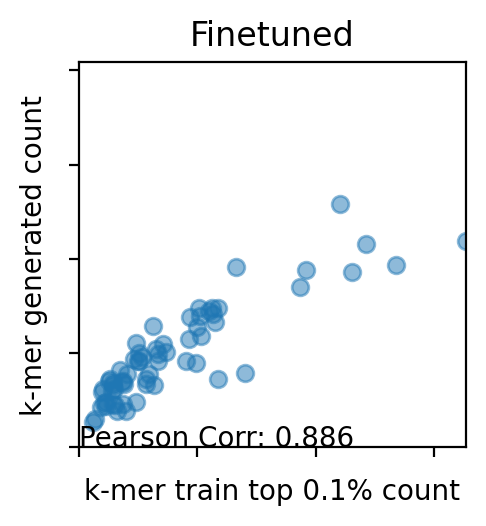

PearsonRResult(statistic=0.8860672291105776, pvalue=2.254595395142767e-22)


In [35]:
compare_kmer(highexp_kmers_999, generated_kmer, n_highexp_kmers_999, len(all_detoeknized_samples), title=r"Finetuned")

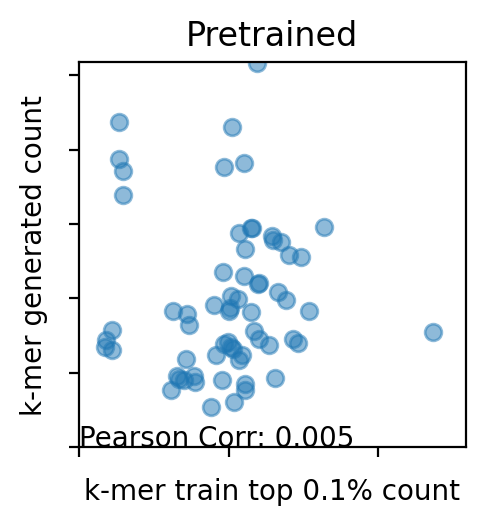

PearsonRResult(statistic=0.004582500540766612, pvalue=0.9713320836990199)


In [36]:
compare_kmer(highexp_kmers_999, old_generated_kmer, n_highexp_kmers_999, len(old_all_detoeknized_samples), title=r"Pretrained")

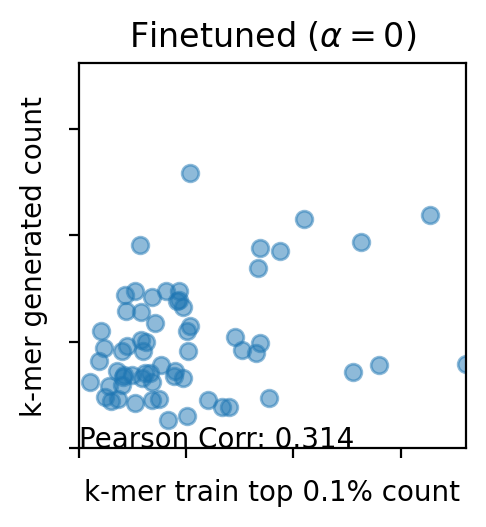

PearsonRResult(statistic=0.3139436696201422, pvalue=0.01152800398180643)


In [37]:
compare_kmer(highexp_kmers_999, zero_alpha_generated_kmer, n_highexp_kmers_999, len(zero_alpha_all_detoeknized_samples), 
             title=r"Finetuned ($\alpha=0$)")

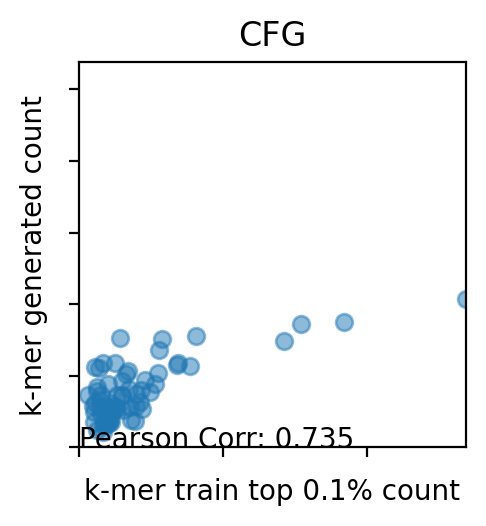

PearsonRResult(statistic=0.7354970023865812, pvalue=4.4598050340444135e-12)


In [38]:
compare_kmer(highexp_kmers_999, cfg_generated_kmer, n_highexp_kmers_999, len(cfg_all_detoeknized_samples), title=r"CFG")

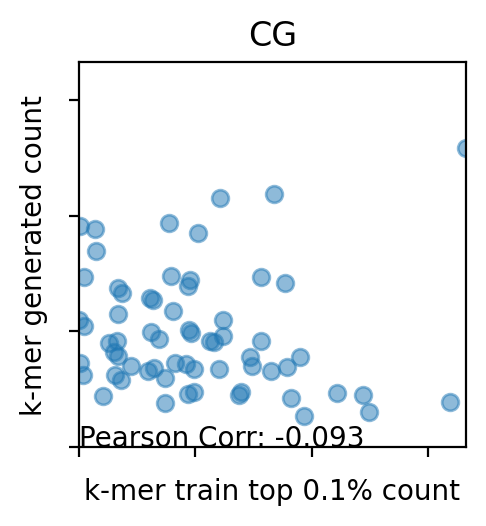

PearsonRResult(statistic=-0.09344226147231928, pvalue=0.4626965705278271)


In [39]:
compare_kmer(highexp_kmers_999, cg_generated_kmer, n_highexp_kmers_999, len(cg_all_detoeknized_samples), title=r"CG")

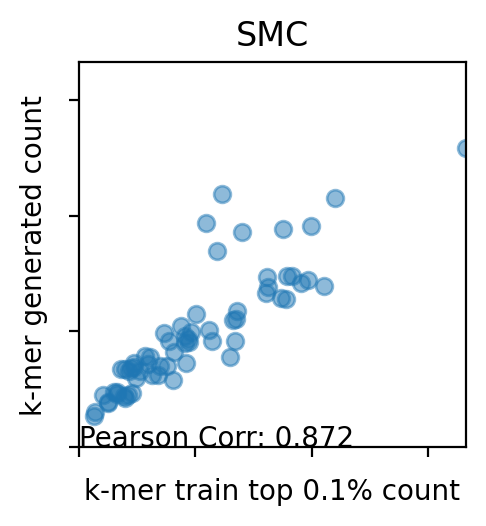

PearsonRResult(statistic=0.8724882170106114, pvalue=6.0004176317850595e-21)


In [40]:
compare_kmer(highexp_kmers_999, smc_generated_kmer, n_highexp_kmers_999, len(smc_all_detoeknized_samples), title=r"SMC")

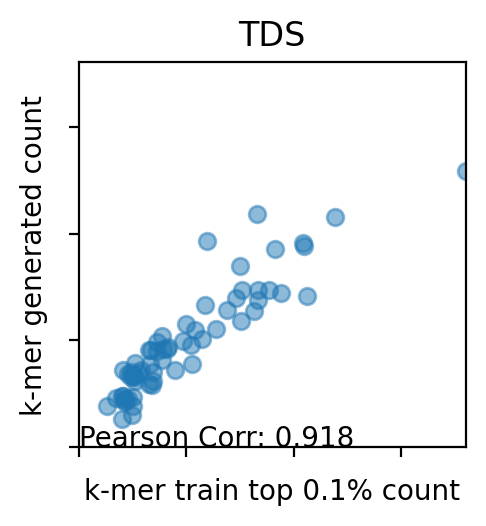

PearsonRResult(statistic=0.9180015862893178, pvalue=1.3682921943163005e-26)


In [41]:
compare_kmer(highexp_kmers_999, tds_generated_kmer, n_highexp_kmers_999, len(tds_all_detoeknized_samples), title=r"TDS")

### JASPER Motif Analysis

In [42]:
from grelu.interpret.motifs import scan_sequences

In [43]:
motif_count = scan_sequences(all_detoeknized_samples, 'jaspar')
motif_count_sum = motif_count['motif'].value_counts()
motif_count_old = scan_sequences(old_all_detoeknized_samples, 'jaspar')
motif_count_old_sum = motif_count_old['motif'].value_counts()
motif_count_zero_alpha = scan_sequences(zero_alpha_all_detoeknized_samples, 'jaspar')
motif_count_zero_alpha_sum = motif_count_zero_alpha['motif'].value_counts()
motif_count_cfg = scan_sequences(cfg_all_detoeknized_samples, 'jaspar')
motif_count_cfg_sum = motif_count_cfg['motif'].value_counts()
motif_count_cg = scan_sequences(cg_all_detoeknized_samples, 'jaspar')
motif_count_cg_sum = motif_count_cg['motif'].value_counts()
motif_count_smc = scan_sequences(smc_all_detoeknized_samples, 'jaspar')
motif_count_smc_sum = motif_count_smc['motif'].value_counts()
motif_count_tds = scan_sequences(tds_all_detoeknized_samples, 'jaspar')
motif_count_tds_sum = motif_count_tds['motif'].value_counts()
motif_count_top = scan_sequences(highexp_seqs_999, 'jaspar')
motif_count_top_sum = motif_count_top['motif'].value_counts()

Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.
Read 1956 motifs from file.


In [44]:
motifs_summary = pd.concat([motif_count_top_sum, motif_count_sum, motif_count_old_sum, motif_count_zero_alpha_sum,
                            motif_count_cfg_sum, motif_count_cg_sum, motif_count_smc_sum, motif_count_tds_sum], axis=1)
motifs_summary.columns = ['top_data', 'finetuend', 'pretrained', 'zero alpha', 'CFG', 'CG', 'SMC', 'TDS']
motifs_summary.corr(method='spearman')

,top_data,finetuend,pretrained,zero alpha,CFG,CG,SMC,TDS
top_data,1.000000,0.909949,0.325957,0.535714,0.850439,-0.013858,0.886063,0.814384
finetuend,0.909949,1.000000,0.121090,0.703986,0.889808,0.050452,0.793862,0.706525
pretrained,0.325957,0.121090,1.000000,-0.024082,0.097635,0.063280,0.482134,0.508198
zero alpha,0.535714,0.703986,-0.024082,1.000000,0.581461,0.197663,0.449238,0.371149
CFG,0.850439,0.889808,0.097635,0.581461,1.000000,0.105628,0.758321,0.671105
CG,-0.013858,0.050452,0.063280,0.197663,0.105628,1.000000,0.001514,0.080289
SMC,0.886063,0.793862,0.482134,0.449238,0.758321,0.001514,1.000000,0.834591
TDS,0.814384,0.706525,0.508198,0.371149,0.671105,0.080289,0.834591,1.000000
